# The following code implements a step-by-step U-net segmentation of ER-network data. Supporting codes are included wherever needed

# Credits to other repositories : 
https://github.com/zhixuhao/unet/ (for preliminary code on u-net, and data augmentation code, data.py (used with modifications)

https://androidkt.com/tensorflow-keras-unet-for-image-image-segmentation/ (for u-net code)

Please change file structure organization according to your own use.

Note : Training data (ERdata_Images/ and ERdata_Masks) as well as test image ("008_colorized-RGB.tif") used here can be provided upon request, by emailing ana057@ucsd.edu. They are not included in the repository due to the large size, as well as ownership issues. Data courtesy Avezov group, Cambridge

In [41]:
# import relevant libraries
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
from tensorflow.keras import backend as K
import pickle

# Following is the u-net neural network. We use an Adam optimizer and a Binary Cross-Entropy loss function for Compilation

In [42]:
# Build U-Net model
IMG_HEIGHT = 512
IMG_WIDTH = 512
IMG_CHANNELS = 1
inputs = tf.keras.layers.Input((IMG_HEIGHT, IMG_WIDTH, IMG_CHANNELS))
# if your images need normalization, replace 1 with the scale needed
s = tf.keras.layers.Lambda(lambda x: x / 1)(inputs)
 
c1 = tf.keras.layers.Conv2D(16, (3, 3), activation=tf.keras.activations.elu, kernel_initializer='he_normal',
                            padding='same')(s)
c1 = tf.keras.layers.Dropout(0.1)(c1)
c1 = tf.keras.layers.Conv2D(16, (3, 3), activation=tf.keras.activations.elu, kernel_initializer='he_normal',
                            padding='same')(c1)
p1 = tf.keras.layers.MaxPooling2D((2, 2))(c1)
 
c2 = tf.keras.layers.Conv2D(32, (3, 3), activation=tf.keras.activations.elu, kernel_initializer='he_normal',
                            padding='same')(p1)
c2 = tf.keras.layers.Dropout(0.1)(c2)
c2 = tf.keras.layers.Conv2D(32, (3, 3), activation=tf.keras.activations.elu, kernel_initializer='he_normal',
                            padding='same')(c2)
p2 = tf.keras.layers.MaxPooling2D((2, 2))(c2)
 
c3 = tf.keras.layers.Conv2D(64, (3, 3), activation=tf.keras.activations.elu, kernel_initializer='he_normal',
                            padding='same')(p2)
c3 = tf.keras.layers.Dropout(0.2)(c3)
c3 = tf.keras.layers.Conv2D(64, (3, 3), activation=tf.keras.activations.elu, kernel_initializer='he_normal',
                            padding='same')(c3)
p3 = tf.keras.layers.MaxPooling2D((2, 2))(c3)
 
c4 = tf.keras.layers.Conv2D(128, (3, 3), activation=tf.keras.activations.elu, kernel_initializer='he_normal',
                            padding='same')(p3)
c4 = tf.keras.layers.Dropout(0.2)(c4)
c4 = tf.keras.layers.Conv2D(128, (3, 3), activation=tf.keras.activations.elu, kernel_initializer='he_normal',
                            padding='same')(c4)
p4 = tf.keras.layers.MaxPooling2D(pool_size=(2, 2))(c4)
 
c5 = tf.keras.layers.Conv2D(256, (3, 3), activation=tf.keras.activations.elu, kernel_initializer='he_normal',
                            padding='same')(p4)
c5 = tf.keras.layers.Dropout(0.3)(c5)
c5 = tf.keras.layers.Conv2D(256, (3, 3), activation=tf.keras.activations.elu, kernel_initializer='he_normal',
                            padding='same')(c5)
 
u6 = tf.keras.layers.Conv2DTranspose(128, (2, 2), strides=(2, 2), padding='same')(c5)
u6 = tf.keras.layers.concatenate([u6, c4])
c6 = tf.keras.layers.Conv2D(128, (3, 3), activation=tf.keras.activations.elu, kernel_initializer='he_normal',
                            padding='same')(u6)
c6 = tf.keras.layers.Dropout(0.2)(c6)
c6 = tf.keras.layers.Conv2D(128, (3, 3), activation=tf.keras.activations.elu, kernel_initializer='he_normal',
                            padding='same')(c6)
 
u7 = tf.keras.layers.Conv2DTranspose(64, (2, 2), strides=(2, 2), padding='same')(c6)
u7 = tf.keras.layers.concatenate([u7, c3])
c7 = tf.keras.layers.Conv2D(64, (3, 3), activation=tf.keras.activations.elu, kernel_initializer='he_normal',
                            padding='same')(u7)
c7 = tf.keras.layers.Dropout(0.2)(c7)
c7 = tf.keras.layers.Conv2D(64, (3, 3), activation=tf.keras.activations.elu, kernel_initializer='he_normal',
                            padding='same')(c7)
 
u8 = tf.keras.layers.Conv2DTranspose(32, (2, 2), strides=(2, 2), padding='same')(c7)
u8 = tf.keras.layers.concatenate([u8, c2])
c8 = tf.keras.layers.Conv2D(32, (3, 3), activation=tf.keras.activations.elu, kernel_initializer='he_normal',
                            padding='same')(u8)
c8 = tf.keras.layers.Dropout(0.1)(c8)
c8 = tf.keras.layers.Conv2D(32, (3, 3), activation=tf.keras.activations.elu, kernel_initializer='he_normal',
                            padding='same')(c8)
 
u9 = tf.keras.layers.Conv2DTranspose(16, (2, 2), strides=(2, 2), padding='same')(c8)
u9 = tf.keras.layers.concatenate([u9, c1], axis=3)
c9 = tf.keras.layers.Conv2D(16, (3, 3), activation=tf.keras.activations.elu, kernel_initializer='he_normal',
                            padding='same')(u9)
c9 = tf.keras.layers.Dropout(0.1)(c9)
c9 = tf.keras.layers.Conv2D(16, (3, 3), activation=tf.keras.activations.elu, kernel_initializer='he_normal',
                            padding='same')(c9)
 
outputs = tf.keras.layers.Conv2D(1, (1, 1), activation='sigmoid')(c9)
#outputs = tf.keras.layers.Conv2D(1, (1, 1), activation='relu')(c9)
 
model = tf.keras.Model(inputs=[inputs], outputs=[outputs])
model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=1e-3), loss='binary_crossentropy', metrics=['accuracy'])
model.summary()

Model: "model_3"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_4 (InputLayer)            [(None, 512, 512, 1) 0                                            
__________________________________________________________________________________________________
lambda_3 (Lambda)               (None, 512, 512, 1)  0           input_4[0][0]                    
__________________________________________________________________________________________________
conv2d_57 (Conv2D)              (None, 512, 512, 16) 160         lambda_3[0][0]                   
__________________________________________________________________________________________________
dropout_27 (Dropout)            (None, 512, 512, 16) 0           conv2d_57[0][0]                  
____________________________________________________________________________________________

# Add the paths to ER image data and masks below. 

In [43]:
import sys
#sys.path.append('/home/anamika/ECE228/ECE228proj/unet-master')
sys.path.append('home/ana057/unet-master/')
from data import *

# Training step, with normalization for masks

In [44]:
# train model with ER data
imgs_train,imgs_mask_train = geneTrainNpy(image_path = "ERdata_Images/", mask_path = "ERdata_Masks/",image_prefix = "Image",mask_prefix = "Mask")
# resize mask only
imgs_mask_train = imgs_mask_train/255;
# Can use checkpoint if needed. 
#model_checkpoint = ModelCheckpoint('unet_membrane.hdf5', monitor='loss',verbose=1)
history = model.fit(imgs_train, imgs_mask_train, batch_size=2, epochs=50, verbose=1,validation_split=0.2, shuffle=True)#, callbacks=[model_checkpoint])


Train on 504 samples, validate on 126 samples
Epoch 1/50
504/504 [==============================] - 19s 38ms/sample - loss: 0.1845 - acc: 0.9176 - val_loss: 0.1668 - val_acc: 0.9249
Epoch 2/50
504/504 [==============================] - 16s 32ms/sample - loss: 0.1488 - acc: 0.9346 - val_loss: 0.1478 - val_acc: 0.9339
Epoch 3/50
504/504 [==============================] - 16s 32ms/sample - loss: 0.1451 - acc: 0.9361 - val_loss: 0.1395 - val_acc: 0.9376
Epoch 4/50
504/504 [==============================] - 17s 33ms/sample - loss: 0.1379 - acc: 0.9391 - val_loss: 0.1329 - val_acc: 0.9413
Epoch 5/50
504/504 [==============================] - 16s 33ms/sample - loss: 0.1360 - acc: 0.9400 - val_loss: 0.2232 - val_acc: 0.8952
Epoch 6/50
504/504 [==============================] - 16s 33ms/sample - loss: 0.1358 - acc: 0.9402 - val_loss: 0.1386 - val_acc: 0.9384
Epoch 7/50
504/504 [==============================] - 16s 32ms/sample - loss: 0.1311 - acc: 0.9422 - val_loss: 0.1256 - val_acc: 0.9441
Ep

# Plot Accuracy and Loss vs Epoch

Text(0, 0.5, 'Loss')

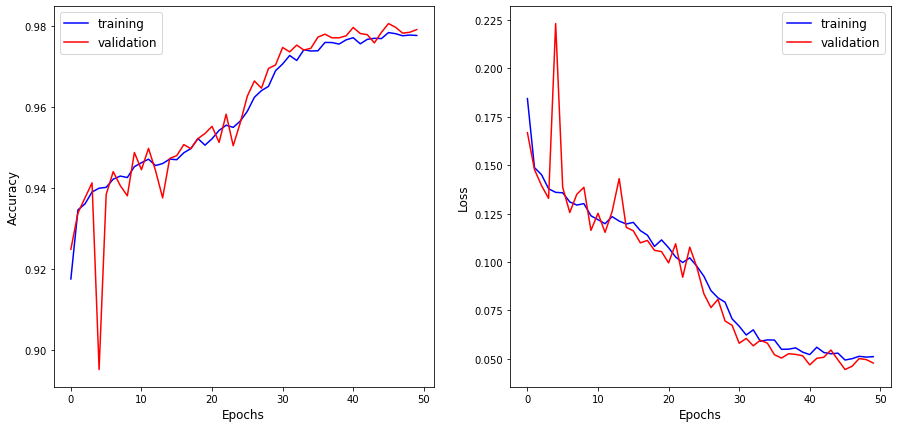

In [46]:
#Plot accuracy vs epoch
plt.figure(figsize=(15,7))
plt.title('Accuracy')
plt.subplot(121)
plt.plot(history.history['acc'], color = 'b')
plt.plot(history.history['val_acc'], color = 'r')
plt.legend(('training','validation'), fontsize=12)
plt.xlabel('Epochs',fontsize = 12)
plt.ylabel('Accuracy',fontsize = 12)
#### Fill in plot ####

#Plot loss vs epoch
plt.subplot(122)
plt.plot(history.history['loss'], color = 'b')
plt.plot(history.history['val_loss'], color = 'r')
plt.legend(('training','validation'), fontsize=12)
plt.xlabel('Epochs',fontsize = 12)
plt.ylabel('Loss',fontsize = 12)

# Import Test image (in our case, a .tif file). Pick a channel and normalize. 

In [31]:
import matplotlib.pyplot as plt
I = plt.imread("008_colorized-RGB.tif")
I = I[:,:,2]
I = I.reshape(1,I.shape[0], I.shape[1],1)/255

# Display the resulting image 

Text(0.5, 1.0, 'Before Segmentation')

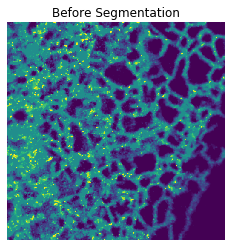

In [49]:
plt.imshow(np.squeeze(I))
plt.axis('off')
plt.title('Before Segmentation')

# Look at the predicted segmentation for one case

1/1 [==============================] - 0s 347ms/sample


Text(0.5, 1.0, 'After Segmentation')

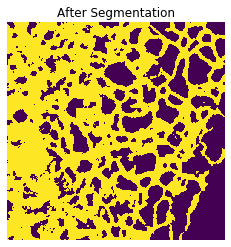

In [50]:
predict = model.predict(I, verbose=1)
 
predict = (predict > 0.9).astype(np.uint8)
 
plt.imshow(np.squeeze(predict[0]))
plt.axis('off')
plt.title('After Segmentation')